<a href="https://colab.research.google.com/github/brahma1995/anomaly_detection/blob/main/product_anomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import cv2,os
import torchvision
import os
import glob
import imgaug.augmenters as iaa
import numpy as np
import os
from PIL import Image
import time

In [2]:
import os
# notice the difference in the URL.
url = "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937370-1629951468/bottle.tar.xz"
# url = "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937545-1629951845/hazelnut.tar.xz"
def download_file(url):

  !wget "$url"

download_file(url)
!tar -xvf bottle.tar.xz
!rm -r bottle.tar.xz

--2023-07-26 10:12:48--  https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937370-1629951468/bottle.tar.xz
Resolving www.mydrive.ch (www.mydrive.ch)... 91.214.169.64
Connecting to www.mydrive.ch (www.mydrive.ch)|91.214.169.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155880244 (149M) [application/x-xz]
Saving to: ‘bottle.tar.xz’

bottle.tar.xz       100%[===================>] 148.66M  71.3MB/s    in 2.1s    

2023-07-26 10:12:51 (71.3 MB/s) - ‘bottle.tar.xz’ saved [155880244/155880244]

bottle/
bottle/ground_truth/
bottle/ground_truth/broken_large/
bottle/ground_truth/broken_large/015_mask.png
bottle/ground_truth/broken_large/016_mask.png
bottle/ground_truth/broken_large/017_mask.png
bottle/ground_truth/broken_large/018_mask.png
bottle/ground_truth/broken_large/019_mask.png
bottle/ground_truth/broken_large/000_mask.png
bottle/ground_truth/broken_large/001_mask.png
bottle/ground_truth/broken_large/002_mask.png
bottle/ground_

In [3]:
!mkdir data
!cp -r  /content/bottle//train/good data
Source_Path = '/content/bottle/test/good'
Destination = '/content/data/good'

for i,filename in enumerate(os.listdir(Source_Path)):

        dst =  "good_" + str(filename)

        # rename all the files
        os.rename(os.path.join(Source_Path, filename),  os.path.join(Destination, dst))

In [4]:
!cp -r  /content/bottle/test/broken_large data
!cp -r  /content/bottle/test/broken_small data
!cp -r  /content/bottle/test/contamination data

In [5]:
!mkdir dataset_folder
# !rm -r dataset_folder
!pip install split-folders

import splitfolders  # or import split_folders

input_folder = '/content/data'

splitfolders.ratio(input_folder, output="dataset_folder",
                   seed=42, ratio=(.7, .2,.1),
                   group_prefix=None) # default values

Copying files: 292 files [00:00, 306.28 files/s]


In [6]:
!rm -r bottle
!rm -r data

In [7]:

input_path = "dataset_folder/train"
import pathlib
data_dir = pathlib.Path(input_path)
print("Total training images = ",len(list(data_dir.glob('*/*.png'))))
import glob
dataset_dict = {
    'broken_large': list(data_dir.glob('broken_large/*')),
    'broken_small': list(data_dir.glob('broken_small/*')),
    'contamination': list(data_dir.glob('contamination/*')),
    'good' : list(data_dir.glob('good/*')),

}

len(dataset_dict['broken_large']),len(dataset_dict['broken_small']),len(dataset_dict['contamination']),len(dataset_dict['good'])

Total training images =  203


(14, 15, 14, 160)

In [8]:

subdirectories = datasets.ImageFolder(input_path)
print(subdirectories.classes)
class_dictionary = {}
for idx, class_name in enumerate(subdirectories.classes):
    class_dictionary[idx] = class_name
class_dictionary

['broken_large', 'broken_small', 'contamination', 'good']


{0: 'broken_large', 1: 'broken_small', 2: 'contamination', 3: 'good'}

Augment to balance class

In [9]:

image_paths = []
labels = []
classes = sorted(os.listdir(input_path))  # Assumes each subdirectory represents a class

for label, class_name in enumerate(classes):
    class_path = os.path.join(input_path, class_name)
    if not os.path.isdir(class_path):
        continue

    # Get all image files in the class directory
    image_files = glob.glob(os.path.join(class_path, '*.png'))

    # Append the image paths and corresponding labels
    image_paths.extend(image_files)
    labels.extend([label] * len(image_files))

# Calculate the number of samples in the majority class
class_counts = np.bincount(labels)
num_samples_majority = np.max(class_counts)
 # Define augmentation transformations
seq = iaa.Sequential([
    iaa.Flipud(p=1.0),   # Vertical flip with probability 1.0 (always applied)
    iaa.Fliplr(p=1.0)
])

# Augment the images to balance the class distribution
for class_label in np.unique(labels):
    class_indices = np.where(np.array(labels) == class_label)[0]
    num_samples_class = len(class_indices)
    # print(num_samples_class)
    num_copies_needed = num_samples_majority - num_samples_class
    # print(class_indices,num_copies_needed)
    # If the class already has enough samples, skip augmentation
    if num_copies_needed <= 0:
        continue

    for idx in class_indices:
        # print(len(class_indices))
        image_path = image_paths[idx]
        # print(image_path)
        image = Image.open(image_path)
        image = np.array(image)
        for _ in range(int(num_copies_needed/ len(class_indices))):
            augmented_image = seq.augment_image(image)
            augmented_image = Image.fromarray(augmented_image)
            image_name = os.path.basename(image_path)
            output_path = os.path.join(data_dir, class_dictionary[class_label], f"{str(time.time())}_{image_name}")
            # print(output_path)
            augmented_image.save(output_path)




Augment Data to 3X

In [10]:
image_paths = []
labels = []
classes = sorted(os.listdir(input_path))  # Assumes each subdirectory represents a class

for label, class_name in enumerate(classes):
    class_path = os.path.join(input_path, class_name)
    if not os.path.isdir(class_path):
        continue

    # Get all image files in the class directory
    image_files = glob.glob(os.path.join(class_path, '*.png'))

    # Append the image paths and corresponding labels
    image_paths.extend(image_files)
    labels.extend([label] * len(image_files))


 # Define augmentation transformations
seq = iaa.Sequential([
    iaa.Fliplr(0.5),         # Horizontal flip with 50% probability
    iaa.Affine(rotate=(-30, 30)),  # Rotate images by -30 to 30 degrees
    iaa.GaussianBlur(sigma=(0, 1.0)),  # Apply Gaussian blur with sigma from 0 to 1.0
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255))  # Add Gaussian noise with std up to 0.05
])
# Print the image paths and corresponding labels
for image_path, label in zip(image_paths, labels):
    # print(f"Image Path: {image_path}, Label: {label}")
    image = Image.open(image_path)
    image = np.array(image)
    for _ in range(3):
      augmented_image = seq.augment_image(image)
      augmented_image = Image.fromarray(augmented_image)
      # string = "dataset_folder/train/good/003.png"
      image_name = image_path.split("/")
      output_path = input_path+"/"+class_dictionary[label]+"/"+str(time.time())+"_"+image_name[-1]
      # print(output_path)
      augmented_image.save(output_path)


print(len(image_paths),len(labels))


618 618


//AUgment Data of validation

In [11]:
# image_paths = []
# labels = []
# input_path = "dataset_folder/val"
# classes = sorted(os.listdir(input_path))  # Assumes each subdirectory represents a class

# for label, class_name in enumerate(classes):
#     class_path = os.path.join(input_path, class_name)
#     if not os.path.isdir(class_path):
#         continue

#     # Get all image files in the class directory
#     image_files = glob.glob(os.path.join(class_path, '*.png'))

#     # Append the image paths and corresponding labels
#     image_paths.extend(image_files)
#     labels.extend([label] * len(image_files))


#  # Define augmentation transformations
# seq = iaa.Sequential([
#     iaa.Fliplr(0.5),         # Horizontal flip with 50% probability
#     iaa.Affine(rotate=(-30, 30)),  # Rotate images by -30 to 30 degrees
#     iaa.GaussianBlur(sigma=(0, 1.0)),  # Apply Gaussian blur with sigma from 0 to 1.0
#     iaa.AdditiveGaussianNoise(scale=(0, 0.05*255))  # Add Gaussian noise with std up to 0.05
# ])
# # Print the image paths and corresponding labels
# for image_path, label in zip(image_paths, labels):
#     # print(f"Image Path: {image_path}, Label: {label}")
#     image = Image.open(image_path)
#     image = np.array(image)
#     for _ in range(2):
#       augmented_image = seq.augment_image(image)
#       augmented_image = Image.fromarray(augmented_image)
#       # string = "dataset_folder/train/good/003.png"
#       image_name = image_path.split("/")
#       output_path = input_path+"/"+class_dictionary[label]+"/"+str(time.time())+"_"+image_name[-1]
#       # print(output_path)
#       augmented_image.save(output_path)


# print(len(image_paths),len(labels))


Augment Images

### 2. Create PyTorch data generators

In [12]:
from torch.utils.data import DataLoader, WeightedRandomSampler
input_path = 'dataset_folder/'
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train':
    datasets.ImageFolder(input_path + 'train', data_transforms['train']),
    'validation':
    datasets.ImageFolder(input_path + 'test', data_transforms['validation'])
}
print(image_datasets['train'].classes)
class_sample_count = torch.tensor([len(np.where(np.array(image_datasets['train'].targets) == t)[0]) for t in range(len(image_datasets['train'].classes))])
weight = 1. / class_sample_count.float()
samples_weight = torch.tensor([weight[t] for t in image_datasets['train'].targets])
sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)



dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                num_workers=0,sampler=sampler),  # for Kaggle
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=0)  # for Kaggle
}

['broken_large', 'broken_small', 'contamination', 'good']


In [13]:
len(image_datasets['train']),len(image_datasets['validation'])

(2472, 32)

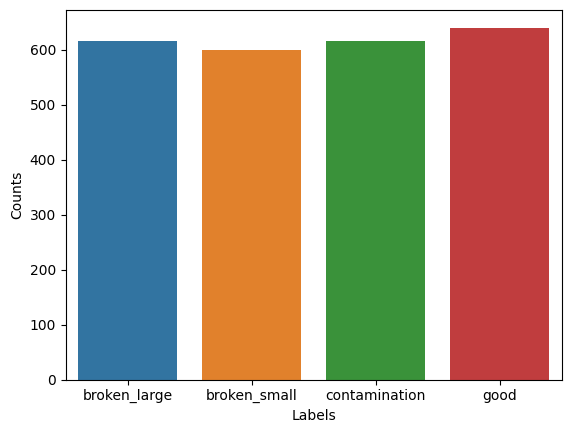

In [14]:

import seaborn as sns


class_names=image_datasets['train'].classes

# Get labels and their counts
labels, counts = np.unique(image_datasets['train'].targets, return_counts=True)
labels_name=[]
for i in labels:
  labels_name.append(class_names[i])


# Plot bar chart
plt.ylabel('Counts')
plt.xlabel('Labels')
sns.barplot(x=labels_name, y=counts)
plt.show()

### 3. Create the network

In [15]:
# from google.colab import files
# import os

# dir_to_zip = '/content/dataset_folder' #@param {type: "string"}
# output_filename = 'file.zip' #@param {type: "string"}
# delete_dir_after_download = "No"  #@param ['Yes', 'No']

# os.system( "zip -r {} {}".format( output_filename , dir_to_zip ) )

# if delete_dir_after_download == "Yes":
#     os.system( "rm -r {}".format( dir_to_zip ) )

# files.download( output_filename )

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [17]:
model = models.resnet18(pretrained=True).to(device)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential( nn.Dropout(0.5),
               nn.Linear(model.fc.in_features, 4)).to(device)
# Modify the last fully connected (fc) layer of the VGG16 model
# model.fc = nn.Sequential(
#     nn.Dropout(0.2),
#     nn.Linear(model.classifier[0].in_features, 4)
# ).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 330MB/s]


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(),lr=0.01,weight_decay=1e-5)
# optimizer = optim.RMSprop(model.fc.parameters(), lr=0.001, alpha=0.9, weight_decay=1e-5)

### 4. Train the model

In [19]:

class EarlyStopping:
    def __init__(self, patience=3, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score
def calculate_metrics(preds, labels):
     # Convert the predicted probabilities to class labels (the class with the highest probability)
    _, pred_labels = torch.max(torch.tensor(preds), dim=1)
    labels_tensor = torch.tensor(labels)

    # Calculate precision, recall, and F1-score
    precision = precision_score(labels_tensor.cpu(), pred_labels.cpu(), average='macro')
    recall = recall_score(labels_tensor.cpu(), pred_labels.cpu(), average='macro')
    f1 = f1_score(labels_tensor.cpu(), pred_labels.cpu(), average='macro')
    return precision, recall, f1

In [21]:
def train_model(model, criterion, optimizer, num_epochs=30, early_stopping=None):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                data_loader = dataloaders['train']
            else:
                model.eval()
                data_loader = dataloaders['validation']

            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []

            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs.requires_grad_(True)  # Set requires_grad=True for outputs
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                # Store predictions and labels for later evaluation
                all_preds.extend(outputs.detach().cpu().numpy())
                all_labels.extend(labels.cpu().numpy())



            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects.double() / len(data_loader.dataset)

            # print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            # Calculate precision, recall, and F1-score for the epoch
            epoch_precision, epoch_recall, epoch_f1 = calculate_metrics(all_preds, all_labels)

            print('{} Loss: {:.4f} Acc: {:.4f} Precision: {:.4f} Recall: {:.4f} F1: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, epoch_precision, epoch_recall, epoch_f1))

            if phase == 'val' and early_stopping is not None:
                early_stopping(epoch_loss)
                if early_stopping.stop:
                    print("Early stopping triggered. Training stopped.")
                    return model

    return model


In [22]:
# model_trained = train_model(model, criterion, optimizer, num_epochs=30)
early_stopping = EarlyStopping(patience=3, delta=0.001)
model_trained = train_model(model, criterion, optimizer, num_epochs=30, early_stopping = early_stopping)

Epoch 1/30
----------


<ipython-input-20-e84c735fcaf6>:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  _, pred_labels = torch.max(torch.tensor(preds), dim=1)


train Loss: 1.1281 Acc: 0.6011 Precision: 0.5990 Recall: 0.5999 F1: 0.5993


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val Loss: 0.3219 Acc: 0.8750 Precision: 0.6058 Recall: 0.6667 F1: 0.6067
Epoch 2/30
----------
train Loss: 0.7701 Acc: 0.7136 Precision: 0.7125 Recall: 0.7133 F1: 0.7129
val Loss: 0.3337 Acc: 0.9062 Precision: 0.8974 Recall: 0.7083 F1: 0.7733
Epoch 3/30
----------
train Loss: 0.7350 Acc: 0.7431 Precision: 0.7410 Recall: 0.7411 F1: 0.7410
val Loss: 0.3001 Acc: 0.9062 Precision: 0.8974 Recall: 0.7083 F1: 0.7733
Epoch 4/30
----------
train Loss: 0.7017 Acc: 0.7561 Precision: 0.7534 Recall: 0.7539 F1: 0.7536


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val Loss: 0.3108 Acc: 0.8750 Precision: 0.6058 Recall: 0.6667 F1: 0.6067
Epoch 5/30
----------
train Loss: 0.7509 Acc: 0.7540 Precision: 0.7501 Recall: 0.7509 F1: 0.7505


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val Loss: 0.5546 Acc: 0.8750 Precision: 0.6058 Recall: 0.6667 F1: 0.6067
Epoch 6/30
----------
train Loss: 0.8034 Acc: 0.7553 Precision: 0.7556 Recall: 0.7562 F1: 0.7557
val Loss: 0.4520 Acc: 0.8750 Precision: 0.6058 Recall: 0.6667 F1: 0.6067
Early stopping triggered. Training stopped.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 5. Save and load the model

In [23]:
!mkdir models
!mkdir models/pytorch

In [24]:
torch.save(model_trained.state_dict(), 'models/pytorch/weights.h5')

In [25]:
model = models.resnet18(pretrained=False).to(device)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Sequential( nn.Dropout(0.5),
               nn.Linear(model.fc.in_features, 4)).to(device)
model.load_state_dict(torch.load('models/pytorch/weights.h5'))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

### 6. Make predictions on sample test images

In [26]:
from typing import List, Tuple

from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):



    img = Image.open(image_path)

    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])




    model.to(device)


    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

    target_image_pred = model(transformed_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)


    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f} | filename: {image_path}")
    plt.axis(False);

In [27]:
class_names=image_datasets['train'].classes

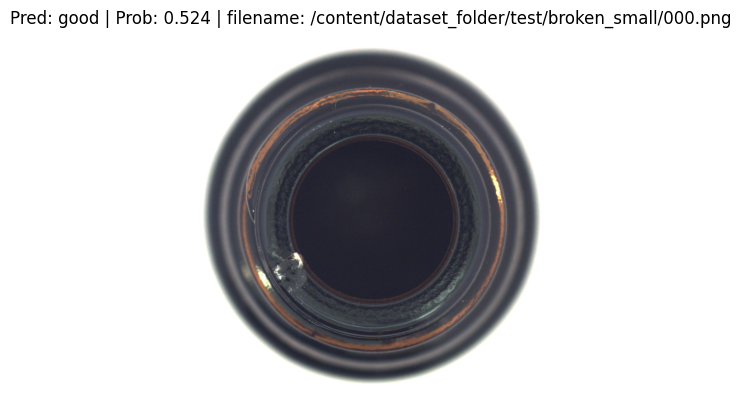

In [30]:
 pred_and_plot_image(model=model,
                        image_path="/content/dataset_folder/test/broken_small/000.png",
                        class_names=class_names,
                        image_size=(224, 224))